# LSTM модель для генерации монофонической музыки

music21 - модуль в python, который позволяет работать с музыкой в формате midi.

In [1]:
from music21 import *
import glob

С помощью программы MuseScore можно также выводить в ноутбуке сами партитуры.

In [2]:
environment.set('musescoreDirectPNGPath', r'C:\Program Files\MuseScore 3\bin\MuseScore3.exe')

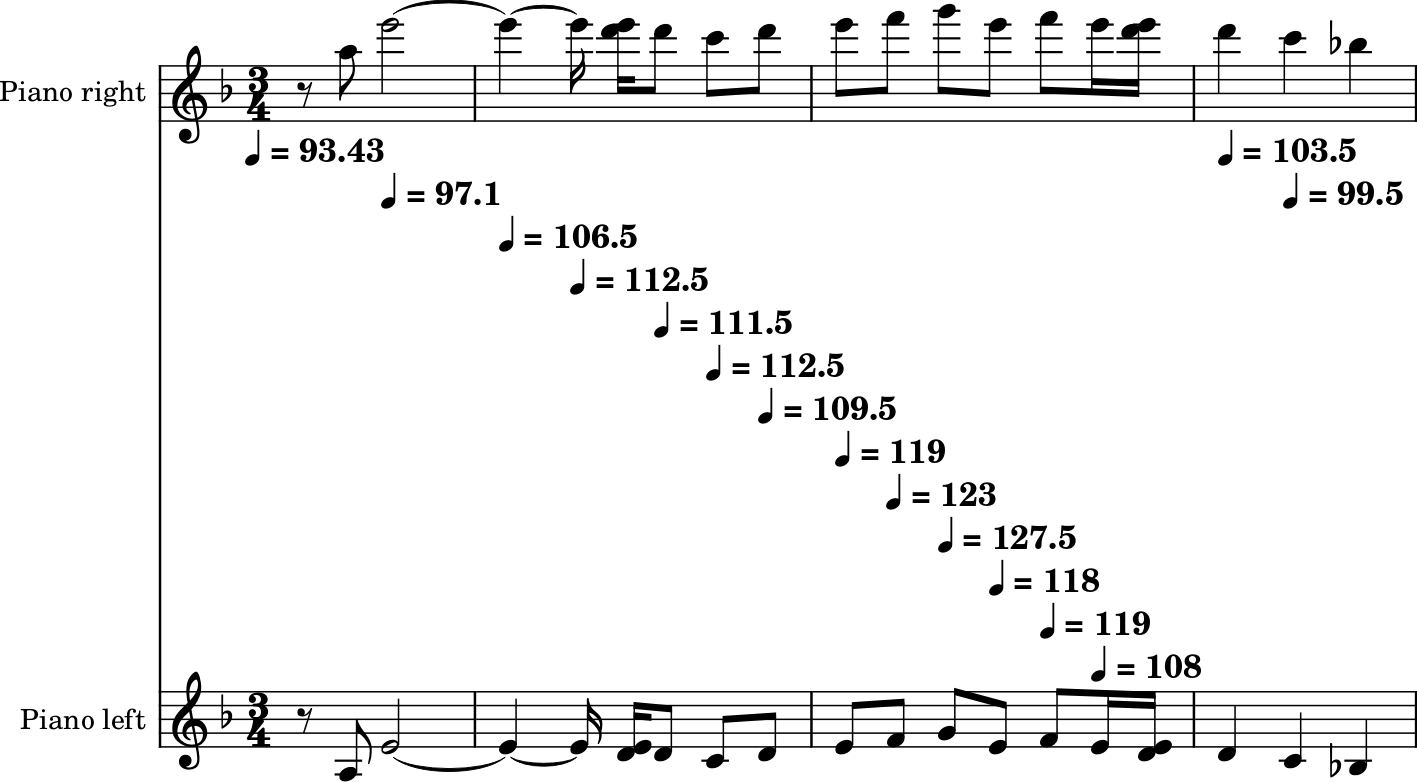

In [3]:
a = converter.parse('small_piano_data/alb_esp1.mid')
a.show()

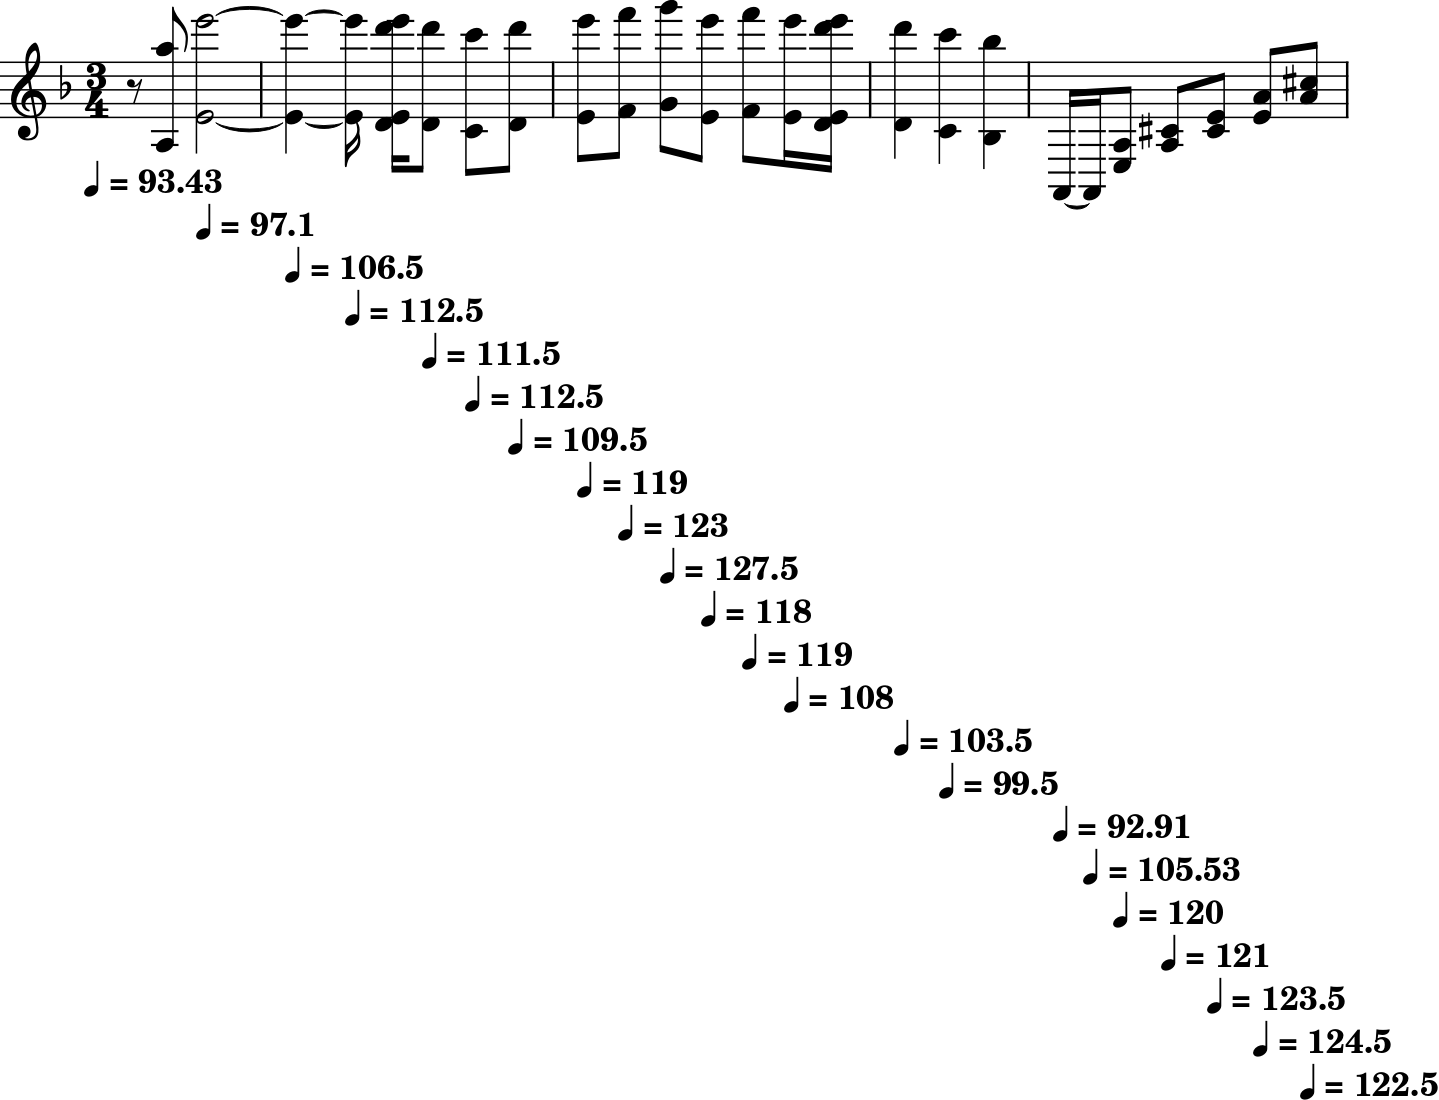

In [4]:
a = a.chordify()
a.show()

Поиск в датасете не обрабатываемых файлов

In [12]:
problem_files=[]
midis = []
for file in glob.glob("smaller_data/*.mid"):
    print(file)
    try:
        midi = converter.parse(file)
        midis.append(midi)
        notes_to_parse = None
        parts = instrument.partitionByInstrument(midi)
    except KeyError:
        problem_files.append(file)

smaller_data\beethoven_hammerklavier_1.mid
smaller_data\beethoven_hammerklavier_2.mid
smaller_data\beethoven_hammerklavier_3.mid
smaller_data\beethoven_hammerklavier_4.mid
smaller_data\beethoven_les_adieux_1.mid
smaller_data\beethoven_les_adieux_2.mid
smaller_data\beethoven_les_adieux_3.mid
smaller_data\beethoven_opus10_1.mid
smaller_data\beethoven_opus10_2.mid
smaller_data\beethoven_opus10_3.mid
smaller_data\beethoven_opus22_1.mid
smaller_data\beethoven_opus22_2.mid
smaller_data\beethoven_opus22_3.mid
smaller_data\beethoven_opus22_4.mid
smaller_data\beethoven_opus90_1.mid
smaller_data\beethoven_opus90_2.mid


Извлекаем из датасета необрабатываемые файлы

In [57]:
parts = instrument.partitionByInstrument(midis[0])
print(parts.parts[1]=='<music21.stream.Part Piano>')
print(parts.parts[1])

False
<music21.stream.Part Piano>


In [58]:
import os, shutil

Обрабатываем весь массив данных. Разбиваем по инструментам, берем только дорожку с основной партией фортепиано. В зависимости от типа элемента либо разбиваем аккорд, либо добавляем ноту.

In [13]:
notes = []
for midi in midis:
    parts = instrument.partitionByInstrument(midi)
    if parts:
        for i in parts.parts:
            if str(i) == '<music21.stream.Part Piano>':
                notes_to_parse = i.recurse()
    else: 
        notes_to_parse = midi.flat.notes

    for element in notes_to_parse:
        if isinstance(element, note.Note): ##если это нота то добавляем высоту в строковом формате
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):##если это аккорд, то добавляем информацию как из аккорда
            notes.append('.'.join(str(n) for n in element.normalOrder))

Таким образом получаем набор нот

In [14]:
len(notes)

42224

In [5]:
import pickle

In [16]:
with open("notes_b", "wb") as fp:   
    pickle.dump(notes, fp)

In [6]:
with open("notes_b", "rb") as fp:   
    notes = pickle.load(fp)

In [7]:
import numpy as np
import keras.utils

Используем последовательности длиной 100 нот. Кодируем ноты с помощью целых чисел. Создаем входную последовательность, нормализуем представления в целых числах.

In [8]:
sequence_length = 100
# берем все ноты
pitchnames = sorted(set(item for item in notes))
# с помощью словаря кодируем ноты в целых числах
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# создаем входную последовательность
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)

network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# нормализуем вход
n_vocab = len(pitchnames)
network_input = network_input / float(n_vocab)
network_output = keras.utils.to_categorical(network_output)

In [11]:
network_input.shape

(42124, 100, 1)

In [9]:
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Dense

Собираем модель, основанную на слоях LSTM, используем также слои Dropout чтобы избежать переобучения.

In [10]:
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    return_sequences=True
))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(n_vocab,activation='Softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [11]:
from keras.callbacks import ModelCheckpoint

Обучение на протяжении 20 эпох, с сохранием весов лучшей модели по метрике ошибок.

In [12]:
filepath = "best_model_big2.hdf5"    
checkpoint = ModelCheckpoint(
    filepath, monitor='loss', 
    verbose=0,        
    save_best_only=True,        
    mode='min'
)    
callbacks_list = [checkpoint]     
model.fit(network_input, network_output, epochs=20, batch_size=64, callbacks=callbacks_list)

Epoch 1/20
659/659 [==============================] - 87s 121ms/step - loss: 4.8640
Epoch 2/20
659/659 [==============================] - 80s 122ms/step - loss: 4.8257
Epoch 3/20
659/659 [==============================] - 81s 123ms/step - loss: 4.8226
Epoch 4/20
659/659 [==============================] - 80s 121ms/step - loss: 4.8212
Epoch 5/20
659/659 [==============================] - 79s 120ms/step - loss: 4.8208
Epoch 6/20
659/659 [==============================] - 79s 120ms/step - loss: 4.8207
Epoch 7/20
659/659 [==============================] - 79s 120ms/step - loss: 4.8210
Epoch 8/20
659/659 [==============================] - 79s 120ms/step - loss: 4.8207
Epoch 9/20
659/659 [==============================] - 79s 120ms/step - loss: 4.8209
Epoch 10/20
659/659 [==============================] - 79s 120ms/step - loss: 4.8219
Epoch 11/20
659/659 [==============================] - 79s 120ms/step - loss: 4.8221
Epoch 12/20
659/659 [==============================] - 79s 120ms/step - lo

In [24]:
model.fit(network_input, network_output, epochs=80, batch_size=64, callbacks=callbacks_list)

Epoch 1/80
659/659 [==============================] - 65s 98ms/step - loss: 3.4992
Epoch 2/80
659/659 [==============================] - 65s 98ms/step - loss: 3.4251
Epoch 3/80
659/659 [==============================] - 65s 99ms/step - loss: 3.3547
Epoch 4/80
659/659 [==============================] - 65s 99ms/step - loss: 3.2755
Epoch 5/80
659/659 [==============================] - 65s 99ms/step - loss: 3.2048
Epoch 6/80
659/659 [==============================] - 65s 99ms/step - loss: 3.1200
Epoch 7/80
659/659 [==============================] - 65s 99ms/step - loss: 3.0439
Epoch 8/80
659/659 [==============================] - 66s 100ms/step - loss: 2.9676
Epoch 9/80
659/659 [==============================] - 66s 99ms/step - loss: 2.8941
Epoch 10/80
659/659 [==============================] - 66s 100ms/step - loss: 2.8240
Epoch 11/80
659/659 [==============================] - 66s 100ms/step - loss: 2.7498
Epoch 12/80
659/659 [==============================] - 66s 99ms/step - loss: 2.697

In [11]:
model.fit(network_input, network_output, epochs=20, batch_size=64, callbacks=callbacks_list)

NameError: name 'callbacks_list' is not defined

In [ ]:
model.

Создание самих семплов, используя случайную стартовую ноту

In [13]:
start = np.random.randint(0, len(network_input)-1)

int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []
# создаем 500 нот
for note_index in range(500):
    
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern = np.append(pattern,index)
    pattern = pattern[1:len(pattern)]

In [29]:
x = np.array([[1,2,3],[1,2,3]])

In [117]:
z = 21567

In [121]:
x.shape

(7,)

In [14]:
offset = 0
output_notes = []
# вновь получаем ноты и аккорды
for pattern in prediction_output:
    # для аккордов
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # для нот
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # каждый раз прибавляем показатель момента времени
    offset += 0.5

In [15]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output_new.mid')

'test_output_new.mid'

In [23]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='test_output2.mid')

'test_output2.mid'

In [10]:
model.load_weights('best_model_big.hdf5')

In [ ]:
model.